In [ ]:
import os
import random
from PIL import Image
import glob
from pathlib import Path
from tqdm import tqdm
import json
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils as utils
from torchvision import datasets
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils
from torchvision import models

import time
from collections import OrderedDict
None

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('content')

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).


In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

### Attack Class

In [ ]:
class Attack(object):

    def __init__(self, name, model):
        self.attack = name
        self._attacks = OrderedDict()

        self.set_model(model)
        try:
            self.device = next(model.parameters()).device
        except Exception:
            self.device = None
            print("Failed to set device automatically, please try set_device() manual.")

        # Controls attack mode.
        self.attack_mode = "default"
        self.supported_mode = ["default"]
        self.targeted = False
        self._target_map_function = None

        # Controls when normalization is used.
        self.normalization_used = None
        self._normalization_applied = None
        if self.model.__class__.__name__ == "RobModel":
            self._set_rmodel_normalization_used(model)

        # Controls model mode during attack.
        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):
        raise NotImplementedError

    def set_model(self, model):
        self.model = model
        self.model_name = model.__class__.__name__

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied is False:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag

    """@wrapper_method"""
    def set_device(self, device):
        self.device = device

    """@wrapper_method"""
    def _set_rmodel_normalization_used(self, model):
        r"""
        Set attack normalization for MAIR [https://github.com/Harry24k/MAIR].

        """
        mean = getattr(model, "mean", None)
        std = getattr(model, "std", None)
        if (mean is not None) and (std is not None):
            if isinstance(mean, torch.Tensor):
                mean = mean.cpu().numpy()
            if isinstance(std, torch.Tensor):
                std = std.cpu().numpy()
            if (mean != 0).all() or (std != 1).all():
                self.set_normalization_used(mean, std)

    """@wrapper_method"""
    def set_normalization_used(self, mean, std):
        self.normalization_used = {}
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used["mean"] = mean
        self.normalization_used["std"] = std
        self._set_normalization_applied(True)

    def normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return inputs * std + mean

    def get_mode(self):
        r"""
        Get attack mode.

        """
        return self.attack_mode

    """@wrapper_method"""
    def set_mode_default(self):
        r"""
        Set attack mode as default mode.

        """
        self.attack_mode = "default"
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    def _set_mode_targeted(self, mode, quiet):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        if not quiet:
            print("Attack mode is changed to '%s'." % mode)

    def set_mode_targeted_by_function(self, target_map_function, quiet=False):
        self._set_mode_targeted("targeted(custom)", quiet)
        self._target_map_function = target_map_function

    def set_mode_targeted_by_label(self, quiet=False):
        self._set_mode_targeted("targeted(label)", quiet)
        self._target_map_function = "function is a string"

    def set_model_training_mode(
        self, model_training=False, batchnorm_training=False, dropout_training=False
    ):
        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if "BatchNorm" in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if "Dropout" in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(
        self,
        data_loader,
        save_path=None,
        verbose=True,
        return_verbose=False,
        save_predictions=False,
        save_clean_inputs=False,
        save_type="float",
    ):
        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    outputs = self.get_output_with_eval_nograd(adv_inputs)

                    # Calculate robust accuracy
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = pred == labels.to(self.device)
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    # Calculate l2 distance
                    delta = (adv_inputs - inputs.to(self.device)).view(
                        batch_size, -1
                    )  # nopep8
                    l2_distance.append(
                        torch.norm(delta[~right_idx], p=2, dim=1)
                    )  # nopep8
                    l2 = torch.cat(l2_distance).mean().item()

                    # Calculate time computation
                    progress = (step + 1) / total_batch * 100
                    end = time.time()
                    elapsed_time = end - start

                    if verbose:
                        self._save_print(
                            progress, rob_acc, l2, elapsed_time, end="\r"
                        )  # nopep8

            if save_path is not None:
                adv_input_list.append(adv_inputs.detach().cpu())
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)

                save_dict = {
                    "adv_inputs": adv_input_list_cat,
                    "labels": label_list_cat,
                }  # nopep8

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict["preds"] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(inputs.detach().cpu())
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict["clean_inputs"] = input_list_cat

                if self.normalization_used is not None:
                    save_dict["adv_inputs"] = self.inverse_normalize(
                        save_dict["adv_inputs"]
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.inverse_normalize(
                            save_dict["clean_inputs"]
                        )  # nopep8

                if save_type == "int":
                    save_dict["adv_inputs"] = self.to_type(
                        save_dict["adv_inputs"], "int"
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.to_type(
                            save_dict["clean_inputs"], "int"
                        )  # nopep8

                save_dict["save_type"] = save_type
                torch.save(save_dict, save_path)

        # To avoid erasing the printed information.
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end="\n")

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    def to_type(inputs, type):
        r"""
        Return inputs as int if float is given.
        """
        if type == "int":
            if isinstance(inputs, torch.FloatTensor) or isinstance(
                inputs, torch.cuda.FloatTensor
            ):
                return (inputs * 255).type(torch.uint8)
        elif type == "float":
            if isinstance(inputs, torch.ByteTensor) or isinstance(
                inputs, torch.cuda.ByteTensor
            ):
                return inputs.float() / 255
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")
        return inputs

    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print(
            "- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t"
            % (progress, rob_acc, l2, elapsed_time),
            end=end,
        )

    def load(
        load_path,
        batch_size=128,
        shuffle=False,
        normalize=None,
        load_predictions=False,
        load_clean_inputs=False,
    ):
        save_dict = torch.load(load_path)
        keys = ["adv_inputs", "labels"]

        if load_predictions:
            keys.append("preds")
        if load_clean_inputs:
            keys.append("clean_inputs")

        if save_dict["save_type"] == "int":
            save_dict["adv_inputs"] = save_dict["adv_inputs"].float() / 255
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"].float() / 255
                )  # nopep8

        if normalize is not None:
            n_channels = len(normalize["mean"])
            mean = torch.tensor(normalize["mean"]).reshape(1, n_channels, 1, 1)
            std = torch.tensor(normalize["std"]).reshape(1, n_channels, 1, 1)
            save_dict["adv_inputs"] = (save_dict["adv_inputs"] - mean) / std
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"] - mean
                ) / std  # nopep8

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(adv_data, batch_size=batch_size, shuffle=shuffle)
        print(
            "Data is loaded in the following order: [%s]" % (", ".join(keys))
        )  # nopep8
        return adv_loader

    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):
        r"""
        Function for changing the attack mode.
        Return input labels.
        """
        if self._target_map_function is None:
            raise ValueError(
                "target_map_function is not initialized by set_mode_targeted."
            )
        if self.attack_mode == "targeted(label)":
            target_labels = labels
        else:
            target_labels = self._target_map_function(inputs, labels)
        return target_labels

    """@torch.no_grad()"""
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l) * torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def __call__(self, inputs, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)

        if self._normalization_applied is True:
            inputs = self.inverse_normalize(inputs)
            self._set_normalization_applied(False)

            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

            adv_inputs = self.normalize(adv_inputs)
            self._set_normalization_applied(True)
        else:
            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

        self._recover_model_mode(given_training)

        return adv_inputs

In [ ]:
class CW(Attack):

    def __init__(self, model, c=3, kappa=0, steps=250, lr=0.01):
        super().__init__("CW", model)
        self.c = c
        self.kappa = kappa
        self.steps = steps
        self.lr = lr
        self.supported_mode = ["default", "targeted"]


    def forward(self, images, labels):

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        w = self.inverse_tanh_delta(images).detach()
        w.requires_grad = True

        best_adv_images = images.clone().detach()
        L2_best = 1e10 * torch.ones((len(images))).to(self.device)
        prev_loss = 1e10
        dim = len(images.shape)

        MSELoss = nn.MSELoss(reduction="none")
        Flatten = nn.Flatten()

        optimizer = optim.Adam([w], lr=self.lr)

        for step in range(self.steps):
            adv_images = self.tanh_delta(w)

            L2_current = MSELoss(Flatten(adv_images), Flatten(images)).sum(dim=1)
            L2_loss = L2_current.sum()

            outputs = self.get_logits(adv_images)

            if not self.targeted:
                f_loss = self.f(outputs, labels).sum()
            else:
                f_loss = self.f(outputs, target_labels).sum()

            loss = L2_loss + self.c * f_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pre = torch.argmax(outputs.detach(), 1)

            if not self.targeted:
                condition = (pre != labels).float()
            else:
                condition = (pre == target_labels).float()

            mask = condition * (L2_best > L2_current.detach())
            L2_best = mask * L2_current.detach() + (1 - mask) * L2_best

            mask = mask.view([-1] + [1] * (dim - 1))
            best_adv_images = mask * adv_images.detach() + (1 - mask) * best_adv_images

            if step % max(self.steps // 10, 1) == 0:
                if loss.item() > prev_loss:
                    return best_adv_images
                prev_loss = loss.item()

        return best_adv_images


    def tanh_delta(self, x):
        return 1 / 2 * (torch.tanh(x) + 1)

     def atanh(self, x):
        return 0.5 * torch.log((1 + x) / (1 - x))

    def inverse_tanh_delta(self, x):
        return self.atanh(torch.clamp(x * 2 - 1, min=-1, max=1))


    def f(self, outputs, labels):
        one_hot_labels = torch.eye(outputs.shape[1]).to(self.device)[labels]

        other = torch.max((1 - one_hot_labels) * outputs, dim=1)[0]
        real = torch.max(one_hot_labels * outputs, dim=1)[0]

        if not self.targeted:
            return torch.clamp((real - other), min=-self.kappa)
        else:
            return torch.clamp((other - real), min=-self.kappa)

### Attack Loop

In [ ]:
def target_f(images, labels):
    return torch.roll(labels, 1)

def attack_loop(model, target_f, test_loader, c, kappa, steps, lr):

    model.to(device).eval()
    attack = CW(model, c, kappa, steps, lr)

    if target_f != None:
        attack.set_mode_targeted_by_function(target_map_function=target_f)

    correct = 0
    total = 0

    for images, labels in tqdm(test_loader):
        if IMAGE_WIDTH * IMAGE_HEIGHT == 784:
            images = torch.autograd.Variable(images.view(-1, IMAGE_WIDTH * IMAGE_HEIGHT))

        images = attack(images, labels)
        labels = labels.to(device)
        outputs = model(images)

        _, pre = torch.max(outputs.data, 1)

        total += 1
        correct += (pre == labels).sum()

    print()
    print('Accuracy of test text: %f %%' % (float(correct) / total))

In [ ]:
c = 64
kappa = 0
steps = 200
lr = 0.01
kappas = [2, 4, 8, 16, 32]

def ATTACK(model, target_f, test_loader, c, steps, lr):
    for kappa in kappas:
        attack_loop(model, target_f, test_loader, c, kappa, steps, lr)

### MNIST DATASET

In [ ]:
train_data = torchvision.datasets.MNIST('./data',download=True)
test_data = torchvision.datasets.MNIST('data',train=False)

Text(0.5, 1.0, 'Label of Image:0')

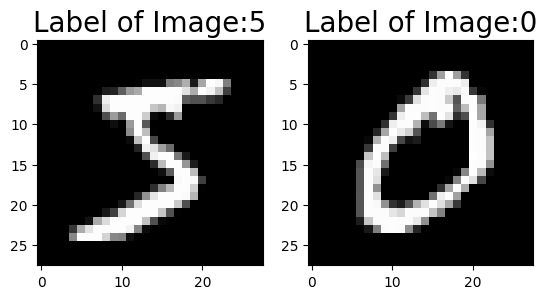

In [ ]:
plt.subplot(1,2,1)
image, label = train_data[0]
plt.imshow(image, cmap='gray')
plt.title("Label of Image:{}".format(label),fontsize=20)
plt.subplot(1,2,2)
image, label = train_data[1]
plt.imshow(image, cmap='gray')
plt.title("Label of Image:{}".format(label),fontsize=20)

In [ ]:
train_data = torchvision.datasets.MNIST('data',train=True,transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST('data',train=False,transform=transforms.ToTensor())

In [ ]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
input_size = IMAGE_WIDTH * IMAGE_HEIGHT
num_classes = 10
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [ ]:
train_dataLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
test_dataLoader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self,input_size,num_classes):
        super(LogisticRegression,self).__init__()
        self.linear = nn.Linear(input_size,num_classes)

    def forward(self,feature):
        output = self.linear(feature)
        return output

In [ ]:
model = LogisticRegression(input_size,num_classes).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [ ]:
for epoch in tqdm(range(num_epochs)):
    for i,(images,labels) in enumerate(train_dataLoader):
        images = torch.autograd.Variable(images.view(-1,input_size)).to(device)
        labels = torch.autograd.Variable(labels).to(device)

        optimizer.zero_grad()
        output = model(images)
        compute_loss = loss(output,labels)
        compute_loss.backward()
        optimizer.step()

100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


In [ ]:
model.eval()

correct = 0
total = 0

for images, labels in test_dataLoader:

    images = torch.autograd.Variable(images.view(-1,input_size)).to(device)
    labels = labels.to(device)
    outputs = model(images)

    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()

print('Accuracy of test text: %f %%' % (float(correct) / total))

Accuracy of test text: 85.320000 %


### Non-targeted Advesarial Attack

In [ ]:
ATTACK(model=model, target_f=None, test_loader=test_dataLoader, c=c, steps=steps, lr=lr)

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]



Accuracy of test text: 3.470000 %


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]



Accuracy of test text: 3.470000 %


100%|██████████| 100/100 [00:38<00:00,  2.62it/s]



Accuracy of test text: 3.470000 %


100%|██████████| 100/100 [00:38<00:00,  2.61it/s]



Accuracy of test text: 3.470000 %


100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Accuracy of test text: 3.470000 %


### Targeted Adversarial Attack

In [ ]:
ATTACK(model=model, target_f=target_f, test_loader=test_dataLoader, c=c, steps=steps, lr=lr)

Attack mode is changed to 'targeted(custom)'.


100%|██████████| 100/100 [00:38<00:00,  2.61it/s]



Accuracy of test text: 48.830000 %
Attack mode is changed to 'targeted(custom)'.


100%|██████████| 100/100 [00:38<00:00,  2.58it/s]



Accuracy of test text: 48.830000 %
Attack mode is changed to 'targeted(custom)'.


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]



Accuracy of test text: 48.830000 %
Attack mode is changed to 'targeted(custom)'.


100%|██████████| 100/100 [00:38<00:00,  2.62it/s]



Accuracy of test text: 48.830000 %
Attack mode is changed to 'targeted(custom)'.


100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


Accuracy of test text: 48.830000 %


### DOGS AND CATS


In [ ]:
"""
train_dir = "training_set"
test_dir = "test_set"
"""
train_dir = "/content/content/MyDrive/InfoSecurity/data/training_set"
test_dir = "/content/content/MyDrive/InfoSecurity/data/test_set"

Random image path: /content/content/MyDrive/InfoSecurity/data/training_set/cats/cat.411.jpg
Image class: cats
Image height: 239
Image width: 320


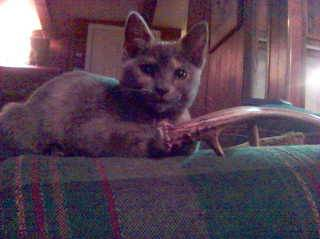

In [ ]:
image_path_list= glob.glob(f"{train_dir}/*/*.jpg")
random_image_path = random.choice(image_path_list)
image_class = Path(random_image_path).parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

data_transform = transforms.Compose([
                 transforms.Resize(size=IMAGE_SIZE),
                 transforms.RandomHorizontalFlip(p=0.5),
                 transforms.ToTensor()
                 ])

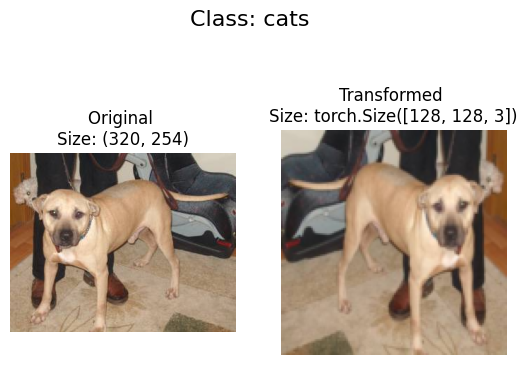

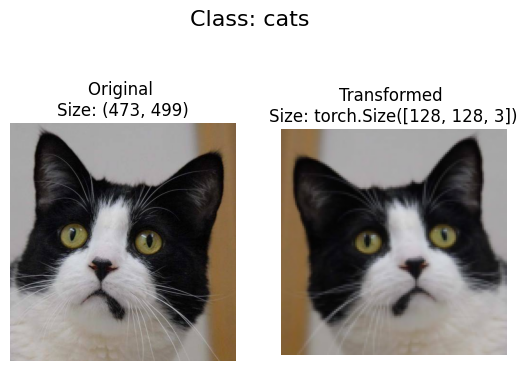

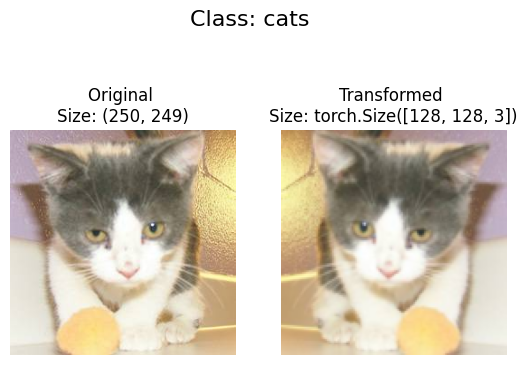

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [ ]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [ ]:
class_names = train_data.classes
print("Class names: ",class_names)

class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)
print("The lengths of the training and test sets: ", len(train_data), len(test_data))

Class names:  ['cats', 'dogs']
Class names as a dict:  {'cats': 0, 'dogs': 1}
The lengths of the training and test sets:  8005 2023


In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.7882, 0.7765, 0.6196,  ..., 0.1608, 0.1608, 0.1569],
         [0.7882, 0.7529, 0.6118,  ..., 0.1490, 0.1490, 0.1529],
         [0.7882, 0.7373, 0.6118,  ..., 0.1333, 0.1333, 0.1490],
         ...,
         [0.1725, 0.2627, 0.2392,  ..., 0.0784, 0.0784, 0.0863],
         [0.1725, 0.1804, 0.2196,  ..., 0.0863, 0.0902, 0.1098],
         [0.1765, 0.1804, 0.2431,  ..., 0.0863, 0.0902, 0.1176]],

        [[0.7725, 0.7686, 0.6235,  ..., 0.1725, 0.1765, 0.1765],
         [0.7686, 0.7373, 0.6118,  ..., 0.1608, 0.1647, 0.1725],
         [0.7608, 0.7137, 0.6039,  ..., 0.1451, 0.1490, 0.1686],
         ...,
         [0.1255, 0.2078, 0.1725,  ..., 0.0706, 0.0706, 0.0784],
         [0.1255, 0.1255, 0.1569,  ..., 0.0784, 0.0824, 0.1020],
         [0.1373, 0.1255, 0.1804,  ..., 0.0784, 0.0824, 0.1098]],

        [[0.6431, 0.6706, 0.5843,  ..., 0.1922, 0.1765, 0.1608],
         [0.6510, 0.6471, 0.5804,  ..., 0.1804, 0.1647, 0.1569],
         [0.6510, 0.6392, 0.5843,  ..., 0.16

Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


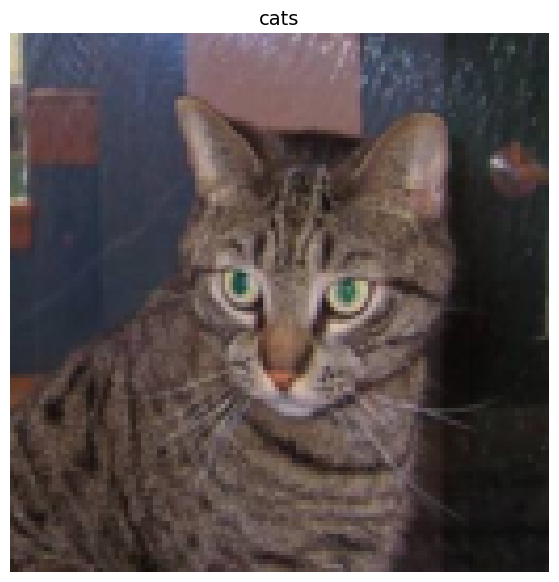

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [ ]:
NUM_WORKERS = 16

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=NUM_WORKERS,
                             shuffle=False)
None

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

train_transform = transforms.Compose([
                  transforms.Resize(IMAGE_SIZE),
                  transforms.TrivialAugmentWide(),
                  transforms.ToTensor()])

test_transform = transforms.Compose([
                 transforms.Resize(IMAGE_SIZE),
                 transforms.ToTensor()])

In [ ]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

BATCH_SIZE = 32

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x

model_cnn = ImageClassifier().to(device)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
try:
    model_cnn.load_state_dict(torch.load('/content/content/MyDrive/InfoSecurity/model_cnn_weights.pth'))

except:
    NUM_EPOCHS = 16
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=1e-3)

    model_cnn_results = train(model=model_cnn,
                          train_dataloader=train_dataloader_augmented,
                          test_dataloader=test_dataloader_augmented,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=NUM_EPOCHS)

    torch.save(model_cnn.state_dict(), '/content/content/MyDrive/InfoSecurity/model_cnn_weights.pth')

### Non-Targeted Adversarial Attack

In [ ]:
ATTACK(model=model_cnn, target_f=None, test_loader=test_dataloader_augmented, c=c, steps=steps, lr=lr)

### Targeted Adversarial Attack

In [ ]:
ATTACK(model=model_cnn, target_f=target_f, test_loader=test_dataloader_augmented, c=c, steps=steps, lr=lr)